In [1]:
# standart libs
import sys
import random
import copy
from operator import itemgetter
from PIL import Image
import time


# 3rd party libs
import pandas as pd
import numpy as np
import gempy as gp
import matplotlib.pyplot as plt
import scipy.stats as ss
from skimage import measure
from matplotlib import gridspec


# local
import functions.realization_setup as real_setup
import functions.realization_run as real_run
import functions.post_processing as post_pro
import functions.uq_runs as uq_runs

WARNING (theano.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


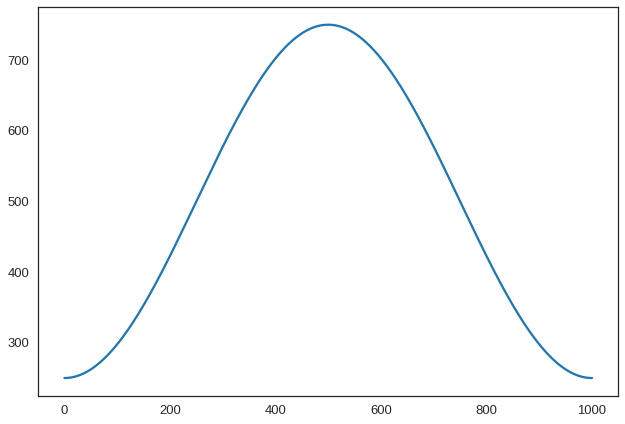

In [2]:
# create basic form
xsim = np.linspace(0, 2 * np.pi, 1000)
ysim = np.cos(xsim) * (-1)
# rescale
xsim = (xsim / (2 * np.pi)) * 1000
ysim = (ysim + 1) * 250 + 250

# create basic form
xcom = np.linspace(0, np.pi, 1000)
ycom = np.exp(-xcom) * np.sin(np.pi * xcom)
# rescale
xcom = (xcom / np.pi) * 1000
ycom -= np.min(ycom)
ycom = (ycom / np.max(ycom)) * 500 + 250

# n-points
def n_points(n, xvals, yvals):
    st = int(xvals.shape[0] / n)
    ss = int(st/2)
    return (xvals[ss::st], yvals[ss::st])

# sample 5 points
xsim_n, ysim_n = n_points(10, xsim, ysim)
xcom_n, ycom_n = n_points(10, xcom, ycom)

# extrema
def extrema(xvals, yvals):
    b0 = (yvals[1:] - yvals[:-1]) > 0
    b1 = b0[1:] ^ b0[:-1]   
    return (xvals[1:-1][b1], yvals[1:-1][b1])

# sample extrema
xsim_ext, ysim_ext = extrema(xsim, ysim)
xcom_ext, ycom_ext = extrema(xcom, ycom)

plt.plot(xsim, ysim)

In [3]:
# instantiate the geo_model
geo_model = gp.create_model("GeoModel")

# defautl data
geo_model = gp.init_data(
    geo_model,
    extent=[0, 1, 0, 1, 0, 1],
    resolution=[1, 1, 1]
)

# compile theno function
gp.set_interpolation_data(
    geo_model,
    compile_theano=True,
    theano_optimizer='fast_run',
)

Active grids: ['regular']
Setting kriging parameters to their default values.
Compiling theano function...
Level of Optimization:  fast_run
Device:  cpu
Precision:  float64
Number of faults:  0
Compilation Done!
Kriging values: 
                     values
range              1.73205
$C_o$            0.0714286
drift equations        [3]


In [4]:
def compare(xline, yline, A):
    """Compared the drawn line with the resutling interpolation.
    Assumes that (including matrix shifting) the shape of the extracted
    line (boolen matrix) equals the shape and coordinates of the drawn
    line.
    """
    # create coordinates to extract from
    _x = np.arange(0, 998, 1)
    X, Y = np.meshgrid(_x, _x)
    xcorr, ycoor = X[A], Y[A]
    # extract the corresponding line point
    # works as boolen matrix idx and line coor are interchangeable
    # !nomralized setting! No generic approach!
    xerr, yerr = xline[xcorr], yline[xcorr] 
    # return
    return (xcorr, ycoor, xerr, yerr) 

def sort_xy(x, y):
    a = np.argsort(x)
    return x[a], y[a]

In [5]:
def comp_3points(p):
     # setup the model input
    extent = [0,1000,0,1000,0,1000]
    section = {
        'p1': [0, 500],
        'p2': [1000, 500],
        'resolution': [1000 - 2, 1000 - 1] # to fit plot shape
    }
    series_df = pd.DataFrame(columns=['name', 'isfault', 'order_series'])
    series_df.loc[0] = { 'order_series': 0, 'name': 'Strat_Series', 'isfault': False }
    xsim_ext, ysim_ext = extrema(xsim, ysim)
    surfaces_df = pd.DataFrame(columns=['name', 'serie', 'order_surface'])
    surfaces_df.loc[0] = { 'name': 'basement', 'serie': 'Basement_Series', 'order_surface': 0 }
    surfaces_df.loc[1] = { 'name': 'rock1', 'serie': 'Strat_Series', 'order_surface': 1 }
    surface_points = pd.DataFrame(columns=['X', 'Y', 'Z', 'surface'])
    surface_points.X = np.array([0, p['x'], 1000])
    surface_points.Y = 500
    surface_points.Z = np.array([250, p['z'], 250])    
    surface_points.surface = 'rock1'
    orientations = pd.DataFrame(columns=['X', 'Y', 'Z', 'dip', 'azimuth', 'polarity', 'formation'])
    orientations.loc[0]=[500, 501, 750, 0, 90, 1, 'rock1']   
    real_setup.setup_realization(
            geo_model=geo_model,
            geo_model_extent=extent,
            section=section,
            series_df=series_df,
            surfaces_df=surfaces_df,
            surface_points_original_df=surface_points,
            orientations_original_df=orientations
    )
    print(geo_model.surface_points.df)
    if real_run.check_setup_single_realization(geo_model):
        solution = gp.compute_model(model=geo_model, sort_surfaces=False)
    Bx = post_pro.compute_boolean_matrix_for_section_surface_top(geo_model)
    A = Bx['0-1']
    # apply
    xcoor, ycoor, xerr, yerr = compare(xsim, ysim, A)
    # calc err
    yerr = ycoor - yerr
    # sort
    xcoor_sorted, ycoor_sorted = sort_xy(xcoor, ycoor)
    xcoor_sorted, yerr_sorted = sort_xy(x=xcoor, y=yerr)
    err_abs = np.sum(np.abs(yerr_sorted))
    return err_abs 

Active grids: ['regular']
Active grids: ['regular' 'sections']
HOTFIX in update_series()
HOTFIX in update_surfaces()
      X    Y    Z     X_r      Y_r     Z_r surface        series  id  \
0     0  500  250  0.2501  0.49985  0.3751   rock1  Strat_Series   2   
1   500  500  750  0.5001  0.49985  0.6251   rock1  Strat_Series   2   
2  1000  500  250  0.7501  0.49985  0.3751   rock1  Strat_Series   2   

   order_series    smooth  
0             1  0.000001  
1             1  0.000001  
2             1  0.000001  
Run realizations setup checks until stable workflow.


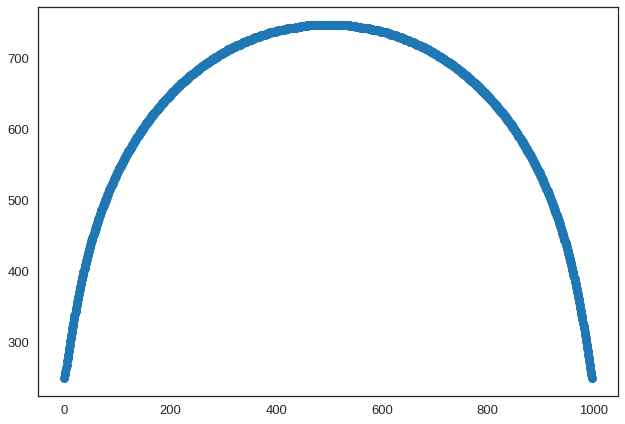

In [6]:
extent = [0,1000,0,1000,0,1000]
section = {
    'p1': [0, 500],
    'p2': [1000, 500],
    'resolution': [1000 - 2, 1000 - 1] # to fit plot shape
}
series_df = pd.DataFrame(columns=['name', 'isfault', 'order_series'])
series_df.loc[0] = { 'order_series': 0, 'name': 'Strat_Series', 'isfault': False }
xsim_ext, ysim_ext = extrema(xsim, ysim)
surfaces_df = pd.DataFrame(columns=['name', 'serie', 'order_surface'])
surfaces_df.loc[0] = { 'name': 'basement', 'serie': 'Basement_Series', 'order_surface': 0 }
surfaces_df.loc[1] = { 'name': 'rock1', 'serie': 'Strat_Series', 'order_surface': 1 }
surface_points = pd.DataFrame(columns=['X', 'Y', 'Z', 'surface'])
surface_points.X = np.array([0, 500, 1000])
surface_points.Y = 500
surface_points.Z = np.array([250, 750, 250])    
surface_points.surface = 'rock1'
orientations = pd.DataFrame(columns=['X', 'Y', 'Z', 'dip', 'azimuth', 'polarity', 'formation'])
orientations.loc[0]=[500, 501, 750, 0, 90, 1, 'rock1']   
real_setup.setup_realization(
        geo_model=geo_model,
        geo_model_extent=extent,
        section=section,
        series_df=series_df,
        surfaces_df=surfaces_df,
        surface_points_original_df=surface_points,
        orientations_original_df=orientations
)
print(geo_model.surface_points.df)
if real_run.check_setup_single_realization(geo_model):
    solution = gp.compute_model(model=geo_model, sort_surfaces=False)
Bx = post_pro.compute_boolean_matrix_for_section_surface_top(geo_model)
A = Bx['0-1']
_x = np.arange(0, 998, 1)
X, Y = np.meshgrid(_x, _x)
xcorr, ycoor = X[A], Y[A]
plt.plot(xcorr, ycoor, 'o')

In [9]:
errs = []
xs = []
# xsim, ysim = xcorr, ycoor
for x in xsim[1::20]:
    i = np.where(xsim == x)
    p = { 'x': x, 'z': ysim[i] }
    xs.append(x)
    errs.append(comp_3points(p))

/home/namur/coding/notebooks/env/lib/python3.6/site-packages/ipykernel_launcher.py:18: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray


Active grids: ['regular' 'sections']
Active grids: ['regular' 'sections']
HOTFIX in update_series()
             X    Y                    Z       X_r      Y_r  \
0     0.000000  500                  250  0.250100  0.49985   
1     1.001001  500  [250.0049446703292]  0.250601  0.49985   
2  1000.000000  500                  250  0.750100  0.49985   

                    Z_r surface        series  id  order_series    smooth  
0                0.3751   rock1  Strat_Series   2             1  0.000001  
1  [0.3751024723351646]   rock1  Strat_Series   2             1  0.000001  
2                0.3751   rock1  Strat_Series   2             1  0.000001  
Run realizations setup checks until stable workflow.


/home/namur/coding/notebooks/env/lib/python3.6/site-packages/ipykernel_launcher.py:18: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray


Active grids: ['regular' 'sections']
Active grids: ['regular' 'sections']
HOTFIX in update_series()
             X    Y                     Z       X_r      Y_r  \
0     0.000000  500                   250  0.250100  0.49985   
1    21.021021  500  [252.17743861553615]  0.260611  0.49985   
2  1000.000000  500                   250  0.750100  0.49985   

                    Z_r surface        series  id  order_series    smooth  
0                0.3751   rock1  Strat_Series   2             1  0.000001  
1  [0.3761887193077681]   rock1  Strat_Series   2             1  0.000001  
2                0.3751   rock1  Strat_Series   2             1  0.000001  
Run realizations setup checks until stable workflow.


/home/namur/coding/notebooks/env/lib/python3.6/site-packages/ipykernel_launcher.py:18: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray


Active grids: ['regular' 'sections']
Active grids: ['regular' 'sections']
HOTFIX in update_series()
             X    Y                    Z       X_r      Y_r  \
0     0.000000  500                  250  0.250100  0.49985   
1    41.041041  500  [258.2660604310004]  0.270621  0.49985   
2  1000.000000  500                  250  0.750100  0.49985   

                    Z_r surface        series  id  order_series    smooth  
0                0.3751   rock1  Strat_Series   2             1  0.000001  
1  [0.3792330302155002]   rock1  Strat_Series   2             1  0.000001  
2                0.3751   rock1  Strat_Series   2             1  0.000001  
Run realizations setup checks until stable workflow.


/home/namur/coding/notebooks/env/lib/python3.6/site-packages/ipykernel_launcher.py:18: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray


Active grids: ['regular' 'sections']
Active grids: ['regular' 'sections']
HOTFIX in update_series()
             X    Y                     Z       X_r      Y_r  \
0     0.000000  500                   250  0.250100  0.49985   
1    61.061061  500  [268.17459683634195]  0.280631  0.49985   
2  1000.000000  500                   250  0.750100  0.49985   

                     Z_r surface        series  id  order_series    smooth  
0                 0.3751   rock1  Strat_Series   2             1  0.000001  
1  [0.38418729841817095]   rock1  Strat_Series   2             1  0.000001  
2                 0.3751   rock1  Strat_Series   2             1  0.000001  
Run realizations setup checks until stable workflow.


/home/namur/coding/notebooks/env/lib/python3.6/site-packages/ipykernel_launcher.py:18: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray


Active grids: ['regular' 'sections']
Active grids: ['regular' 'sections']
HOTFIX in update_series()
             X    Y                   Z       X_r      Y_r  \
0     0.000000  500                 250  0.250100  0.49985   
1    81.081081  500  [281.746471709703]  0.290641  0.49985   
2  1000.000000  500                 250  0.750100  0.49985   

                     Z_r surface        series  id  order_series    smooth  
0                 0.3751   rock1  Strat_Series   2             1  0.000001  
1  [0.39097323585485144]   rock1  Strat_Series   2             1  0.000001  
2                 0.3751   rock1  Strat_Series   2             1  0.000001  
Run realizations setup checks until stable workflow.


/home/namur/coding/notebooks/env/lib/python3.6/site-packages/ipykernel_launcher.py:18: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray


Active grids: ['regular' 'sections']
Active grids: ['regular' 'sections']
HOTFIX in update_series()
             X    Y                    Z       X_r      Y_r  \
0     0.000000  500                  250  0.250100  0.49985   
1   101.101101  500  [298.7672203262163]  0.300651  0.49985   
2  1000.000000  500                  250  0.750100  0.49985   

                    Z_r surface        series  id  order_series    smooth  
0                0.3751   rock1  Strat_Series   2             1  0.000001  
1  [0.3994836101631082]   rock1  Strat_Series   2             1  0.000001  
2                0.3751   rock1  Strat_Series   2             1  0.000001  
Run realizations setup checks until stable workflow.


/home/namur/coding/notebooks/env/lib/python3.6/site-packages/ipykernel_launcher.py:18: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray


Active grids: ['regular' 'sections']
Active grids: ['regular' 'sections']
HOTFIX in update_series()
             X    Y                     Z       X_r      Y_r  \
0     0.000000  500                   250  0.250100  0.49985   
1   121.121121  500  [318.96787836052994]  0.310661  0.49985   
2  1000.000000  500                   250  0.750100  0.49985   

                   Z_r surface        series  id  order_series    smooth  
0               0.3751   rock1  Strat_Series   2             1  0.000001  
1  [0.409583939180265]   rock1  Strat_Series   2             1  0.000001  
2               0.3751   rock1  Strat_Series   2             1  0.000001  
Run realizations setup checks until stable workflow.


/home/namur/coding/notebooks/env/lib/python3.6/site-packages/ipykernel_launcher.py:18: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray


Active grids: ['regular' 'sections']
Active grids: ['regular' 'sections']
HOTFIX in update_series()
             X    Y                     Z       X_r      Y_r  \
0     0.000000  500                   250  0.250100  0.49985   
1   141.141141  500  [342.02923209988194]  0.320671  0.49985   
2  1000.000000  500                   250  0.750100  0.49985   

                     Z_r surface        series  id  order_series    smooth  
0                 0.3751   rock1  Strat_Series   2             1  0.000001  
1  [0.42111461604994094]   rock1  Strat_Series   2             1  0.000001  
2                 0.3751   rock1  Strat_Series   2             1  0.000001  
Run realizations setup checks until stable workflow.


/home/namur/coding/notebooks/env/lib/python3.6/site-packages/ipykernel_launcher.py:18: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray


Active grids: ['regular' 'sections']
Active grids: ['regular' 'sections']
HOTFIX in update_series()
             X    Y                     Z       X_r      Y_r  \
0     0.000000  500                   250  0.250100  0.49985   
1   161.161161  500  [367.58686270524487]  0.330681  0.49985   
2  1000.000000  500                   250  0.750100  0.49985   

                    Z_r surface        series  id  order_series    smooth  
0                0.3751   rock1  Strat_Series   2             1  0.000001  
1  [0.4338934313526224]   rock1  Strat_Series   2             1  0.000001  
2                0.3751   rock1  Strat_Series   2             1  0.000001  
Run realizations setup checks until stable workflow.


/home/namur/coding/notebooks/env/lib/python3.6/site-packages/ipykernel_launcher.py:18: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray


Active grids: ['regular' 'sections']
Active grids: ['regular' 'sections']
HOTFIX in update_series()
             X    Y                    Z       X_r      Y_r  \
0     0.000000  500                  250  0.250100  0.49985   
1   181.181181  500  [395.2369048103975]  0.340691  0.49985   
2  1000.000000  500                  250  0.750100  0.49985   

                     Z_r surface        series  id  order_series    smooth  
0                 0.3751   rock1  Strat_Series   2             1  0.000001  
1  [0.44771845240519875]   rock1  Strat_Series   2             1  0.000001  
2                 0.3751   rock1  Strat_Series   2             1  0.000001  
Run realizations setup checks until stable workflow.


/home/namur/coding/notebooks/env/lib/python3.6/site-packages/ipykernel_launcher.py:18: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray


Active grids: ['regular' 'sections']
Active grids: ['regular' 'sections']
HOTFIX in update_series()
             X    Y                     Z       X_r      Y_r  \
0     0.000000  500                   250  0.250100  0.49985   
1   201.201201  500  [424.54242846071077]  0.350701  0.49985   
2  1000.000000  500                   250  0.750100  0.49985   

                    Z_r surface        series  id  order_series    smooth  
0                0.3751   rock1  Strat_Series   2             1  0.000001  
1  [0.4623712142303554]   rock1  Strat_Series   2             1  0.000001  
2                0.3751   rock1  Strat_Series   2             1  0.000001  
Run realizations setup checks until stable workflow.


/home/namur/coding/notebooks/env/lib/python3.6/site-packages/ipykernel_launcher.py:18: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray


Active grids: ['regular' 'sections']
Active grids: ['regular' 'sections']
HOTFIX in update_series()
             X    Y                     Z       X_r      Y_r  \
0     0.000000  500                   250  0.250100  0.49985   
1   221.221221  500  [455.04034354333004]  0.360711  0.49985   
2  1000.000000  500                   250  0.750100  0.49985   

                   Z_r surface        series  id  order_series    smooth  
0               0.3751   rock1  Strat_Series   2             1  0.000001  
1  [0.477620171771665]   rock1  Strat_Series   2             1  0.000001  
2               0.3751   rock1  Strat_Series   2             1  0.000001  
Run realizations setup checks until stable workflow.


/home/namur/coding/notebooks/env/lib/python3.6/site-packages/ipykernel_launcher.py:18: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray


Active grids: ['regular' 'sections']
Active grids: ['regular' 'sections']
HOTFIX in update_series()
             X    Y                    Z       X_r      Y_r  \
0     0.000000  500                  250  0.250100  0.49985   
1   241.241241  500  [486.2487176039517]  0.370721  0.49985   
2  1000.000000  500                  250  0.750100  0.49985   

                     Z_r surface        series  id  order_series    smooth  
0                 0.3751   rock1  Strat_Series   2             1  0.000001  
1  [0.49322435880197585]   rock1  Strat_Series   2             1  0.000001  
2                 0.3751   rock1  Strat_Series   2             1  0.000001  
Run realizations setup checks until stable workflow.


/home/namur/coding/notebooks/env/lib/python3.6/site-packages/ipykernel_launcher.py:18: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray


Active grids: ['regular' 'sections']
Active grids: ['regular' 'sections']
HOTFIX in update_series()
             X    Y                    Z       X_r      Y_r  \
0     0.000000  500                  250  0.250100  0.49985   
1   261.261261  500  [517.6743914129986]  0.380731  0.49985   
2  1000.000000  500                  250  0.750100  0.49985   

                    Z_r surface        series  id  order_series    smooth  
0                0.3751   rock1  Strat_Series   2             1  0.000001  
1  [0.5089371957064993]   rock1  Strat_Series   2             1  0.000001  
2                0.3751   rock1  Strat_Series   2             1  0.000001  
Run realizations setup checks until stable workflow.


/home/namur/coding/notebooks/env/lib/python3.6/site-packages/ipykernel_launcher.py:18: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray


Active grids: ['regular' 'sections']
Active grids: ['regular' 'sections']
HOTFIX in update_series()
             X    Y                    Z       X_r      Y_r  \
0     0.000000  500                  250  0.250100  0.49985   
1   281.281281  500  [548.8207719389175]  0.390741  0.49985   
2  1000.000000  500                  250  0.750100  0.49985   

                    Z_r surface        series  id  order_series    smooth  
0                0.3751   rock1  Strat_Series   2             1  0.000001  
1  [0.5245103859694588]   rock1  Strat_Series   2             1  0.000001  
2                0.3751   rock1  Strat_Series   2             1  0.000001  
Run realizations setup checks until stable workflow.


/home/namur/coding/notebooks/env/lib/python3.6/site-packages/ipykernel_launcher.py:18: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray


Active grids: ['regular' 'sections']
Active grids: ['regular' 'sections']
HOTFIX in update_series()
             X    Y                    Z       X_r      Y_r  \
0     0.000000  500                  250  0.250100  0.49985   
1   301.301301  500  [579.1956795829105]  0.400751  0.49985   
2  1000.000000  500                  250  0.750100  0.49985   

                    Z_r surface        series  id  order_series    smooth  
0                0.3751   rock1  Strat_Series   2             1  0.000001  
1  [0.5396978397914552]   rock1  Strat_Series   2             1  0.000001  
2                0.3751   rock1  Strat_Series   2             1  0.000001  
Run realizations setup checks until stable workflow.


/home/namur/coding/notebooks/env/lib/python3.6/site-packages/ipykernel_launcher.py:18: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray


Active grids: ['regular' 'sections']
Active grids: ['regular' 'sections']
HOTFIX in update_series()
             X    Y                    Z       X_r      Y_r  \
0     0.000000  500                  250  0.250100  0.49985   
1   321.321321  500  [608.3191256719672]  0.410761  0.49985   
2  1000.000000  500                  250  0.750100  0.49985   

                    Z_r surface        series  id  order_series    smooth  
0                0.3751   rock1  Strat_Series   2             1  0.000001  
1  [0.5542595628359835]   rock1  Strat_Series   2             1  0.000001  
2                0.3751   rock1  Strat_Series   2             1  0.000001  
Run realizations setup checks until stable workflow.


/home/namur/coding/notebooks/env/lib/python3.6/site-packages/ipykernel_launcher.py:18: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray


Active grids: ['regular' 'sections']
Active grids: ['regular' 'sections']
HOTFIX in update_series()
             X    Y                    Z       X_r      Y_r  \
0     0.000000  500                  250  0.250100  0.49985   
1   341.341341  500  [635.7308973091248]  0.420771  0.49985   
2  1000.000000  500                  250  0.750100  0.49985   

                    Z_r surface        series  id  order_series    smooth  
0                0.3751   rock1  Strat_Series   2             1  0.000001  
1  [0.5679654486545623]   rock1  Strat_Series   2             1  0.000001  
2                0.3751   rock1  Strat_Series   2             1  0.000001  
Run realizations setup checks until stable workflow.


/home/namur/coding/notebooks/env/lib/python3.6/site-packages/ipykernel_launcher.py:18: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray


Active grids: ['regular' 'sections']
Active grids: ['regular' 'sections']
HOTFIX in update_series()
             X    Y                    Z       X_r      Y_r  \
0     0.000000  500                  250  0.250100  0.49985   
1   361.361361  500  [660.9978297240671]  0.430781  0.49985   
2  1000.000000  500                  250  0.750100  0.49985   

                    Z_r surface        series  id  order_series    smooth  
0                0.3751   rock1  Strat_Series   2             1  0.000001  
1  [0.5805989148620335]   rock1  Strat_Series   2             1  0.000001  
2                0.3751   rock1  Strat_Series   2             1  0.000001  
Run realizations setup checks until stable workflow.


/home/namur/coding/notebooks/env/lib/python3.6/site-packages/ipykernel_launcher.py:18: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray


Active grids: ['regular' 'sections']
Active grids: ['regular' 'sections']
HOTFIX in update_series()
             X    Y                   Z       X_r      Y_r  \
0     0.000000  500                 250  0.250100  0.49985   
1   381.381381  500  [683.720651205319]  0.440791  0.49985   
2  1000.000000  500                 250  0.750100  0.49985   

                    Z_r surface        series  id  order_series    smooth  
0                0.3751   rock1  Strat_Series   2             1  0.000001  
1  [0.5919603256026594]   rock1  Strat_Series   2             1  0.000001  
2                0.3751   rock1  Strat_Series   2             1  0.000001  
Run realizations setup checks until stable workflow.


/home/namur/coding/notebooks/env/lib/python3.6/site-packages/ipykernel_launcher.py:18: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray


Active grids: ['regular' 'sections']
Active grids: ['regular' 'sections']
HOTFIX in update_series()
             X    Y                    Z       X_r      Y_r  \
0     0.000000  500                  250  0.250100  0.49985   
1   401.401401  500  [703.5402924494381]  0.450801  0.49985   
2  1000.000000  500                  250  0.750100  0.49985   

                   Z_r surface        series  id  order_series    smooth  
0               0.3751   rock1  Strat_Series   2             1  0.000001  
1  [0.601870146224719]   rock1  Strat_Series   2             1  0.000001  
2               0.3751   rock1  Strat_Series   2             1  0.000001  
Run realizations setup checks until stable workflow.


/home/namur/coding/notebooks/env/lib/python3.6/site-packages/ipykernel_launcher.py:18: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray


Active grids: ['regular' 'sections']
Active grids: ['regular' 'sections']
HOTFIX in update_series()
             X    Y                    Z       X_r      Y_r  \
0     0.000000  500                  250  0.250100  0.49985   
1   421.421421  500  [720.1435606259536]  0.460811  0.49985   
2  1000.000000  500                  250  0.750100  0.49985   

                    Z_r surface        series  id  order_series    smooth  
0                0.3751   rock1  Strat_Series   2             1  0.000001  
1  [0.6101717803129768]   rock1  Strat_Series   2             1  0.000001  
2                0.3751   rock1  Strat_Series   2             1  0.000001  
Run realizations setup checks until stable workflow.


/home/namur/coding/notebooks/env/lib/python3.6/site-packages/ipykernel_launcher.py:18: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray


Active grids: ['regular' 'sections']
Active grids: ['regular' 'sections']
HOTFIX in update_series()
             X    Y                    Z       X_r      Y_r  \
0     0.000000  500                  250  0.250100  0.49985   
1   441.441441  500  [733.2680884956593]  0.470821  0.49985   
2  1000.000000  500                  250  0.750100  0.49985   

                    Z_r surface        series  id  order_series    smooth  
0                0.3751   rock1  Strat_Series   2             1  0.000001  
1  [0.6167340442478296]   rock1  Strat_Series   2             1  0.000001  
2                0.3751   rock1  Strat_Series   2             1  0.000001  
Run realizations setup checks until stable workflow.


/home/namur/coding/notebooks/env/lib/python3.6/site-packages/ipykernel_launcher.py:18: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray


Active grids: ['regular' 'sections']
Active grids: ['regular' 'sections']
HOTFIX in update_series()
             X    Y                    Z       X_r      Y_r  \
0     0.000000  500                  250  0.250100  0.49985   
1   461.461461  500  [742.7064803755819]  0.480831  0.49985   
2  1000.000000  500                  250  0.750100  0.49985   

                    Z_r surface        series  id  order_series    smooth  
0                0.3751   rock1  Strat_Series   2             1  0.000001  
1  [0.6214532401877909]   rock1  Strat_Series   2             1  0.000001  
2                0.3751   rock1  Strat_Series   2             1  0.000001  
Run realizations setup checks until stable workflow.


/home/namur/coding/notebooks/env/lib/python3.6/site-packages/ipykernel_launcher.py:18: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray


Active grids: ['regular' 'sections']
Active grids: ['regular' 'sections']
HOTFIX in update_series()
             X    Y                    Z       X_r      Y_r  \
0     0.000000  500                  250  0.250100  0.49985   
1   481.481481  500  [748.3095894354858]  0.490841  0.49985   
2  1000.000000  500                  250  0.750100  0.49985   

                    Z_r surface        series  id  order_series    smooth  
0                0.3751   rock1  Strat_Series   2             1  0.000001  
1  [0.6242547947177429]   rock1  Strat_Series   2             1  0.000001  
2                0.3751   rock1  Strat_Series   2             1  0.000001  
Run realizations setup checks until stable workflow.


/home/namur/coding/notebooks/env/lib/python3.6/site-packages/ipykernel_launcher.py:18: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray


Active grids: ['regular' 'sections']
Active grids: ['regular' 'sections']
HOTFIX in update_series()
             X    Y                    Z       X_r      Y_r  \
0     0.000000  500                  250  0.250100  0.49985   
1   501.501502  500  [749.9888745376028]  0.500851  0.49985   
2  1000.000000  500                  250  0.750100  0.49985   

                    Z_r surface        series  id  order_series    smooth  
0                0.3751   rock1  Strat_Series   2             1  0.000001  
1  [0.6250944372688014]   rock1  Strat_Series   2             1  0.000001  
2                0.3751   rock1  Strat_Series   2             1  0.000001  
Run realizations setup checks until stable workflow.


/home/namur/coding/notebooks/env/lib/python3.6/site-packages/ipykernel_launcher.py:18: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray


Active grids: ['regular' 'sections']
Active grids: ['regular' 'sections']
HOTFIX in update_series()
             X    Y                    Z       X_r      Y_r  \
0     0.000000  500                  250  0.250100  0.49985   
1   521.521522  500  [747.7177993764659]  0.510861  0.49985   
2  1000.000000  500                  250  0.750100  0.49985   

                    Z_r surface        series  id  order_series    smooth  
0                0.3751   rock1  Strat_Series   2             1  0.000001  
1  [0.6239588996882329]   rock1  Strat_Series   2             1  0.000001  
2                0.3751   rock1  Strat_Series   2             1  0.000001  
Run realizations setup checks until stable workflow.


/home/namur/coding/notebooks/env/lib/python3.6/site-packages/ipykernel_launcher.py:18: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray


Active grids: ['regular' 'sections']
Active grids: ['regular' 'sections']
HOTFIX in update_series()
             X    Y                    Z       X_r      Y_r  \
0     0.000000  500                  250  0.250100  0.49985   
1   541.541542  500  [741.5322518094371]  0.520871  0.49985   
2  1000.000000  500                  250  0.750100  0.49985   

                    Z_r surface        series  id  order_series    smooth  
0                0.3751   rock1  Strat_Series   2             1  0.000001  
1  [0.6208661259047186]   rock1  Strat_Series   2             1  0.000001  
2                0.3751   rock1  Strat_Series   2             1  0.000001  
Run realizations setup checks until stable workflow.


/home/namur/coding/notebooks/env/lib/python3.6/site-packages/ipykernel_launcher.py:18: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray


Active grids: ['regular' 'sections']
Active grids: ['regular' 'sections']
HOTFIX in update_series()
             X    Y                    Z       X_r      Y_r  \
0     0.000000  500                  250  0.250100  0.49985   
1   561.561562  500  [731.5299767516065]  0.530881  0.49985   
2  1000.000000  500                  250  0.750100  0.49985   

                    Z_r surface        series  id  order_series    smooth  
0                0.3751   rock1  Strat_Series   2             1  0.000001  
1  [0.6158649883758032]   rock1  Strat_Series   2             1  0.000001  
2                0.3751   rock1  Strat_Series   2             1  0.000001  
Run realizations setup checks until stable workflow.


/home/namur/coding/notebooks/env/lib/python3.6/site-packages/ipykernel_launcher.py:18: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray


Active grids: ['regular' 'sections']
Active grids: ['regular' 'sections']
HOTFIX in update_series()
             X    Y                    Z       X_r      Y_r  \
0     0.000000  500                  250  0.250100  0.49985   
1   581.581582  500  [717.8690315965432]  0.540891  0.49985   
2  1000.000000  500                  250  0.750100  0.49985   

                    Z_r surface        series  id  order_series    smooth  
0                0.3751   rock1  Strat_Series   2             1  0.000001  
1  [0.6090345157982716]   rock1  Strat_Series   2             1  0.000001  
2                0.3751   rock1  Strat_Series   2             1  0.000001  
Run realizations setup checks until stable workflow.


/home/namur/coding/notebooks/env/lib/python3.6/site-packages/ipykernel_launcher.py:18: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray


Active grids: ['regular' 'sections']
Active grids: ['regular' 'sections']
HOTFIX in update_series()
             X    Y                    Z       X_r      Y_r  \
0     0.000000  500                  250  0.250100  0.49985   
1   601.601602  500  [700.7652885705564]  0.550901  0.49985   
2  1000.000000  500                  250  0.750100  0.49985   

                    Z_r surface        series  id  order_series    smooth  
0                0.3751   rock1  Strat_Series   2             1  0.000001  
1  [0.6004826442852782]   rock1  Strat_Series   2             1  0.000001  
2                0.3751   rock1  Strat_Series   2             1  0.000001  
Run realizations setup checks until stable workflow.


/home/namur/coding/notebooks/env/lib/python3.6/site-packages/ipykernel_launcher.py:18: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray


Active grids: ['regular' 'sections']
Active grids: ['regular' 'sections']
HOTFIX in update_series()
             X    Y                    Z       X_r      Y_r  \
0     0.000000  500                  250  0.250100  0.49985   
1   621.621622  500  [680.4890234886311]  0.560911  0.49985   
2  1000.000000  500                  250  0.750100  0.49985   

                    Z_r surface        series  id  order_series    smooth  
0                0.3751   rock1  Strat_Series   2             1  0.000001  
1  [0.5903445117443156]   rock1  Strat_Series   2             1  0.000001  
2                0.3751   rock1  Strat_Series   2             1  0.000001  
Run realizations setup checks until stable workflow.


/home/namur/coding/notebooks/env/lib/python3.6/site-packages/ipykernel_launcher.py:18: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray


Active grids: ['regular' 'sections']
Active grids: ['regular' 'sections']
HOTFIX in update_series()
             X    Y                   Z       X_r      Y_r  \
0     0.000000  500                 250  0.250100  0.49985   
1   641.641642  500  [657.360644817004]  0.570921  0.49985   
2  1000.000000  500                 250  0.750100  0.49985   

                   Z_r surface        series  id  order_series    smooth  
0               0.3751   rock1  Strat_Series   2             1  0.000001  
1  [0.578780322408502]   rock1  Strat_Series   2             1  0.000001  
2               0.3751   rock1  Strat_Series   2             1  0.000001  
Run realizations setup checks until stable workflow.


/home/namur/coding/notebooks/env/lib/python3.6/site-packages/ipykernel_launcher.py:18: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray


Active grids: ['regular' 'sections']
Active grids: ['regular' 'sections']
HOTFIX in update_series()
             X    Y                    Z       X_r      Y_r  \
0     0.000000  500                  250  0.250100  0.49985   
1   661.661662  500  [631.7456305323526]  0.580931  0.49985   
2  1000.000000  500                  250  0.750100  0.49985   

                    Z_r surface        series  id  order_series    smooth  
0                0.3751   rock1  Strat_Series   2             1  0.000001  
1  [0.5659728152661763]   rock1  Strat_Series   2             1  0.000001  
2                0.3751   rock1  Strat_Series   2             1  0.000001  
Run realizations setup checks until stable workflow.


/home/namur/coding/notebooks/env/lib/python3.6/site-packages/ipykernel_launcher.py:18: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray


Active grids: ['regular' 'sections']
Active grids: ['regular' 'sections']
HOTFIX in update_series()
             X    Y                    Z       X_r      Y_r  \
0     0.000000  500                  250  0.250100  0.49985   
1   681.681682  500  [604.0487527860771]  0.590941  0.49985   
2  1000.000000  500                  250  0.750100  0.49985   

                    Z_r surface        series  id  order_series    smooth  
0                0.3751   rock1  Strat_Series   2             1  0.000001  
1  [0.5521243763930386]   rock1  Strat_Series   2             1  0.000001  
2                0.3751   rock1  Strat_Series   2             1  0.000001  
Run realizations setup checks until stable workflow.


/home/namur/coding/notebooks/env/lib/python3.6/site-packages/ipykernel_launcher.py:18: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray


Active grids: ['regular' 'sections']
Active grids: ['regular' 'sections']
HOTFIX in update_series()
             X    Y                    Z       X_r      Y_r  \
0     0.000000  500                  250  0.250100  0.49985   
1   701.701702  500  [574.7076816363651]  0.600951  0.49985   
2  1000.000000  500                  250  0.750100  0.49985   

                    Z_r surface        series  id  order_series    smooth  
0                0.3751   rock1  Strat_Series   2             1  0.000001  
1  [0.5374538408181826]   rock1  Strat_Series   2             1  0.000001  
2                0.3751   rock1  Strat_Series   2             1  0.000001  
Run realizations setup checks until stable workflow.


/home/namur/coding/notebooks/env/lib/python3.6/site-packages/ipykernel_launcher.py:18: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray


Active grids: ['regular' 'sections']
Active grids: ['regular' 'sections']
HOTFIX in update_series()
             X    Y                    Z       X_r      Y_r  \
0     0.000000  500                  250  0.250100  0.49985   
1   721.721722  500  [544.1860689227854]  0.610961  0.49985   
2  1000.000000  500                  250  0.750100  0.49985   

                    Z_r surface        series  id  order_series    smooth  
0                0.3751   rock1  Strat_Series   2             1  0.000001  
1  [0.5221930344613926]   rock1  Strat_Series   2             1  0.000001  
2                0.3751   rock1  Strat_Series   2             1  0.000001  
Run realizations setup checks until stable workflow.


/home/namur/coding/notebooks/env/lib/python3.6/site-packages/ipykernel_launcher.py:18: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray


Active grids: ['regular' 'sections']
Active grids: ['regular' 'sections']
HOTFIX in update_series()
             X    Y                    Z       X_r      Y_r  \
0     0.000000  500                  250  0.250100  0.49985   
1   741.741742  500  [512.9662215730255]  0.620971  0.49985   
2  1000.000000  500                  250  0.750100  0.49985   

                    Z_r surface        series  id  order_series    smooth  
0                0.3751   rock1  Strat_Series   2             1  0.000001  
1  [0.5065831107865127]   rock1  Strat_Series   2             1  0.000001  
2                0.3751   rock1  Strat_Series   2             1  0.000001  
Run realizations setup checks until stable workflow.


/home/namur/coding/notebooks/env/lib/python3.6/site-packages/ipykernel_launcher.py:18: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray


Active grids: ['regular' 'sections']
Active grids: ['regular' 'sections']
HOTFIX in update_series()
             X    Y                     Z       X_r      Y_r  \
0     0.000000  500                   250  0.250100  0.49985   
1   761.761762  500  [481.54148011923223]  0.630981  0.49985   
2  1000.000000  500                   250  0.750100  0.49985   

                    Z_r surface        series  id  order_series    smooth  
0                0.3751   rock1  Strat_Series   2             1  0.000001  
1  [0.4908707400596161]   rock1  Strat_Series   2             1  0.000001  
2                0.3751   rock1  Strat_Series   2             1  0.000001  
Run realizations setup checks until stable workflow.


/home/namur/coding/notebooks/env/lib/python3.6/site-packages/ipykernel_launcher.py:18: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray


Active grids: ['regular' 'sections']
Active grids: ['regular' 'sections']
HOTFIX in update_series()
             X    Y                    Z       X_r      Y_r  \
0     0.000000  500                  250  0.250100  0.49985   
1   781.781782  500  [450.4084228597469]  0.640991  0.49985   
2  1000.000000  500                  250  0.750100  0.49985   

                     Z_r surface        series  id  order_series    smooth  
0                 0.3751   rock1  Strat_Series   2             1  0.000001  
1  [0.47530421142987345]   rock1  Strat_Series   2             1  0.000001  
2                 0.3751   rock1  Strat_Series   2             1  0.000001  
Run realizations setup checks until stable workflow.


/home/namur/coding/notebooks/env/lib/python3.6/site-packages/ipykernel_launcher.py:18: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray


Active grids: ['regular' 'sections']
Active grids: ['regular' 'sections']
HOTFIX in update_series()
             X    Y                    Z       X_r      Y_r  \
0     0.000000  500                  250  0.250100  0.49985   
1   801.801802  500  [420.0590188571888]  0.651001  0.49985   
2  1000.000000  500                  250  0.750100  0.49985   

                    Z_r surface        series  id  order_series    smooth  
0                0.3751   rock1  Strat_Series   2             1  0.000001  
1  [0.4601295094285944]   rock1  Strat_Series   2             1  0.000001  
2                0.3751   rock1  Strat_Series   2             1  0.000001  
Run realizations setup checks until stable workflow.


/home/namur/coding/notebooks/env/lib/python3.6/site-packages/ipykernel_launcher.py:18: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray


Active grids: ['regular' 'sections']
Active grids: ['regular' 'sections']
HOTFIX in update_series()
             X    Y                    Z       X_r      Y_r  \
0     0.000000  500                  250  0.250100  0.49985   
1   821.821822  500  [390.9728537723473]  0.661011  0.49985   
2  1000.000000  500                  250  0.750100  0.49985   

                     Z_r surface        series  id  order_series    smooth  
0                 0.3751   rock1  Strat_Series   2             1  0.000001  
1  [0.44558642688617367]   rock1  Strat_Series   2             1  0.000001  
2                 0.3751   rock1  Strat_Series   2             1  0.000001  
Run realizations setup checks until stable workflow.


/home/namur/coding/notebooks/env/lib/python3.6/site-packages/ipykernel_launcher.py:18: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray


Active grids: ['regular' 'sections']
Active grids: ['regular' 'sections']
HOTFIX in update_series()
             X    Y                    Z       X_r      Y_r  \
0     0.000000  500                  250  0.250100  0.49985   
1   841.841842  500  [363.6095513823772]  0.671021  0.49985   
2  1000.000000  500                  250  0.750100  0.49985   

                     Z_r surface        series  id  order_series    smooth  
0                 0.3751   rock1  Strat_Series   2             1  0.000001  
1  [0.43190477569118857]   rock1  Strat_Series   2             1  0.000001  
2                 0.3751   rock1  Strat_Series   2             1  0.000001  
Run realizations setup checks until stable workflow.


/home/namur/coding/notebooks/env/lib/python3.6/site-packages/ipykernel_launcher.py:18: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray


Active grids: ['regular' 'sections']
Active grids: ['regular' 'sections']
HOTFIX in update_series()
             X    Y                    Z       X_r      Y_r  \
0     0.000000  500                  250  0.250100  0.49985   
1   861.861862  500  [338.4015105395578]  0.681031  0.49985   
2  1000.000000  500                  250  0.750100  0.49985   

                    Z_r surface        series  id  order_series    smooth  
0                0.3751   rock1  Strat_Series   2             1  0.000001  
1  [0.4193007552697789]   rock1  Strat_Series   2             1  0.000001  
2                0.3751   rock1  Strat_Series   2             1  0.000001  
Run realizations setup checks until stable workflow.


/home/namur/coding/notebooks/env/lib/python3.6/site-packages/ipykernel_launcher.py:18: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray


Active grids: ['regular' 'sections']
Active grids: ['regular' 'sections']
HOTFIX in update_series()
             X    Y                    Z       X_r      Y_r  \
0     0.000000  500                  250  0.250100  0.49985   
1   881.881882  500  [315.7470723422448]  0.691041  0.49985   
2  1000.000000  500                  250  0.750100  0.49985   

                    Z_r surface        series  id  order_series    smooth  
0                0.3751   rock1  Strat_Series   2             1  0.000001  
1  [0.4079735361711224]   rock1  Strat_Series   2             1  0.000001  
2                0.3751   rock1  Strat_Series   2             1  0.000001  
Run realizations setup checks until stable workflow.


/home/namur/coding/notebooks/env/lib/python3.6/site-packages/ipykernel_launcher.py:18: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray


Active grids: ['regular' 'sections']
Active grids: ['regular' 'sections']
HOTFIX in update_series()
             X    Y                    Z       X_r      Y_r  \
0     0.000000  500                  250  0.250100  0.49985   
1   901.901902  500  [296.0042254913614]  0.701051  0.49985   
2  1000.000000  500                  250  0.750100  0.49985   

                    Z_r surface        series  id  order_series    smooth  
0                0.3751   rock1  Strat_Series   2             1  0.000001  
1  [0.3981021127456807]   rock1  Strat_Series   2             1  0.000001  
2                0.3751   rock1  Strat_Series   2             1  0.000001  
Run realizations setup checks until stable workflow.


/home/namur/coding/notebooks/env/lib/python3.6/site-packages/ipykernel_launcher.py:18: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray


Active grids: ['regular' 'sections']
Active grids: ['regular' 'sections']
HOTFIX in update_series()
             X    Y                     Z       X_r      Y_r  \
0     0.000000  500                   250  0.250100  0.49985   
1   921.921922  500  [279.48494930129726]  0.711061  0.49985   
2  1000.000000  500                   250  0.750100  0.49985   

                     Z_r surface        series  id  order_series    smooth  
0                 0.3751   rock1  Strat_Series   2             1  0.000001  
1  [0.38984247465064864]   rock1  Strat_Series   2             1  0.000001  
2                 0.3751   rock1  Strat_Series   2             1  0.000001  
Run realizations setup checks until stable workflow.


/home/namur/coding/notebooks/env/lib/python3.6/site-packages/ipykernel_launcher.py:18: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray


Active grids: ['regular' 'sections']
Active grids: ['regular' 'sections']
HOTFIX in update_series()
             X    Y                     Z       X_r      Y_r  \
0     0.000000  500                   250  0.250100  0.49985   
1   941.941942  500  [266.45028375777014]  0.721071  0.49985   
2  1000.000000  500                   250  0.750100  0.49985   

                     Z_r surface        series  id  order_series    smooth  
0                 0.3751   rock1  Strat_Series   2             1  0.000001  
1  [0.38332514187888506]   rock1  Strat_Series   2             1  0.000001  
2                 0.3751   rock1  Strat_Series   2             1  0.000001  
Run realizations setup checks until stable workflow.


/home/namur/coding/notebooks/env/lib/python3.6/site-packages/ipykernel_launcher.py:18: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray


Active grids: ['regular' 'sections']
Active grids: ['regular' 'sections']
HOTFIX in update_series()
             X    Y                     Z       X_r      Y_r  \
0     0.000000  500                   250  0.250100  0.49985   
1   961.961962  500  [257.10620452630997]  0.731081  0.49985   
2  1000.000000  500                   250  0.750100  0.49985   

                     Z_r surface        series  id  order_series    smooth  
0                 0.3751   rock1  Strat_Series   2             1  0.000001  
1  [0.37865310226315496]   rock1  Strat_Series   2             1  0.000001  
2                 0.3751   rock1  Strat_Series   2             1  0.000001  
Run realizations setup checks until stable workflow.


/home/namur/coding/notebooks/env/lib/python3.6/site-packages/ipykernel_launcher.py:18: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray


Active grids: ['regular' 'sections']
Active grids: ['regular' 'sections']
HOTFIX in update_series()
             X    Y                     Z       X_r      Y_r  \
0     0.000000  500                   250  0.250100  0.49985   
1   981.981982  500  [251.60036809507426]  0.741091  0.49985   
2  1000.000000  500                   250  0.750100  0.49985   

                    Z_r surface        series  id  order_series    smooth  
0                0.3751   rock1  Strat_Series   2             1  0.000001  
1  [0.3759001840475371]   rock1  Strat_Series   2             1  0.000001  
2                0.3751   rock1  Strat_Series   2             1  0.000001  
Run realizations setup checks until stable workflow.


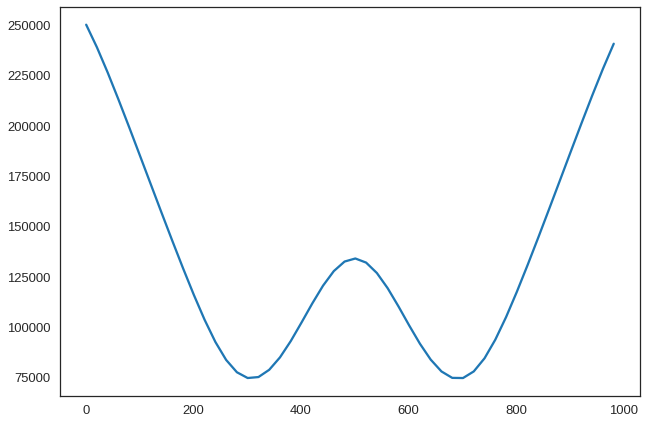

In [10]:
plt.plot(xs, errs)